In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_path = "heart_disease_uci.csv"
df = pd.read_csv(dataset_path)

In [3]:
print(df.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


### **Handling Missing Values**

In [4]:
columns_to_exclude = ['id', 'age', 'sex','dataset','cp','num']
columns_to_fix = [col for col in df.columns if col not in columns_to_exclude]
for col in columns_to_fix:
    missing_mask = (df[col].isnull())
    most_frequent = df.loc[~missing_mask, col].mode()[0]
    df.loc[missing_mask, col] = most_frequent

In [5]:
print(df.isnull().sum())

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [6]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [7]:
df_processed = df.copy()

### **Droping irrelevant columns**

In [8]:
df_processed = df_processed.drop(['id', 'dataset'], axis=1)

### **Converting Categorical cols**

In [9]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le 

In [10]:
df_processed.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,2
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0


In [11]:
X = df_processed.drop('num', axis=1)
y = (df_processed['num'] > 0).astype(int) 

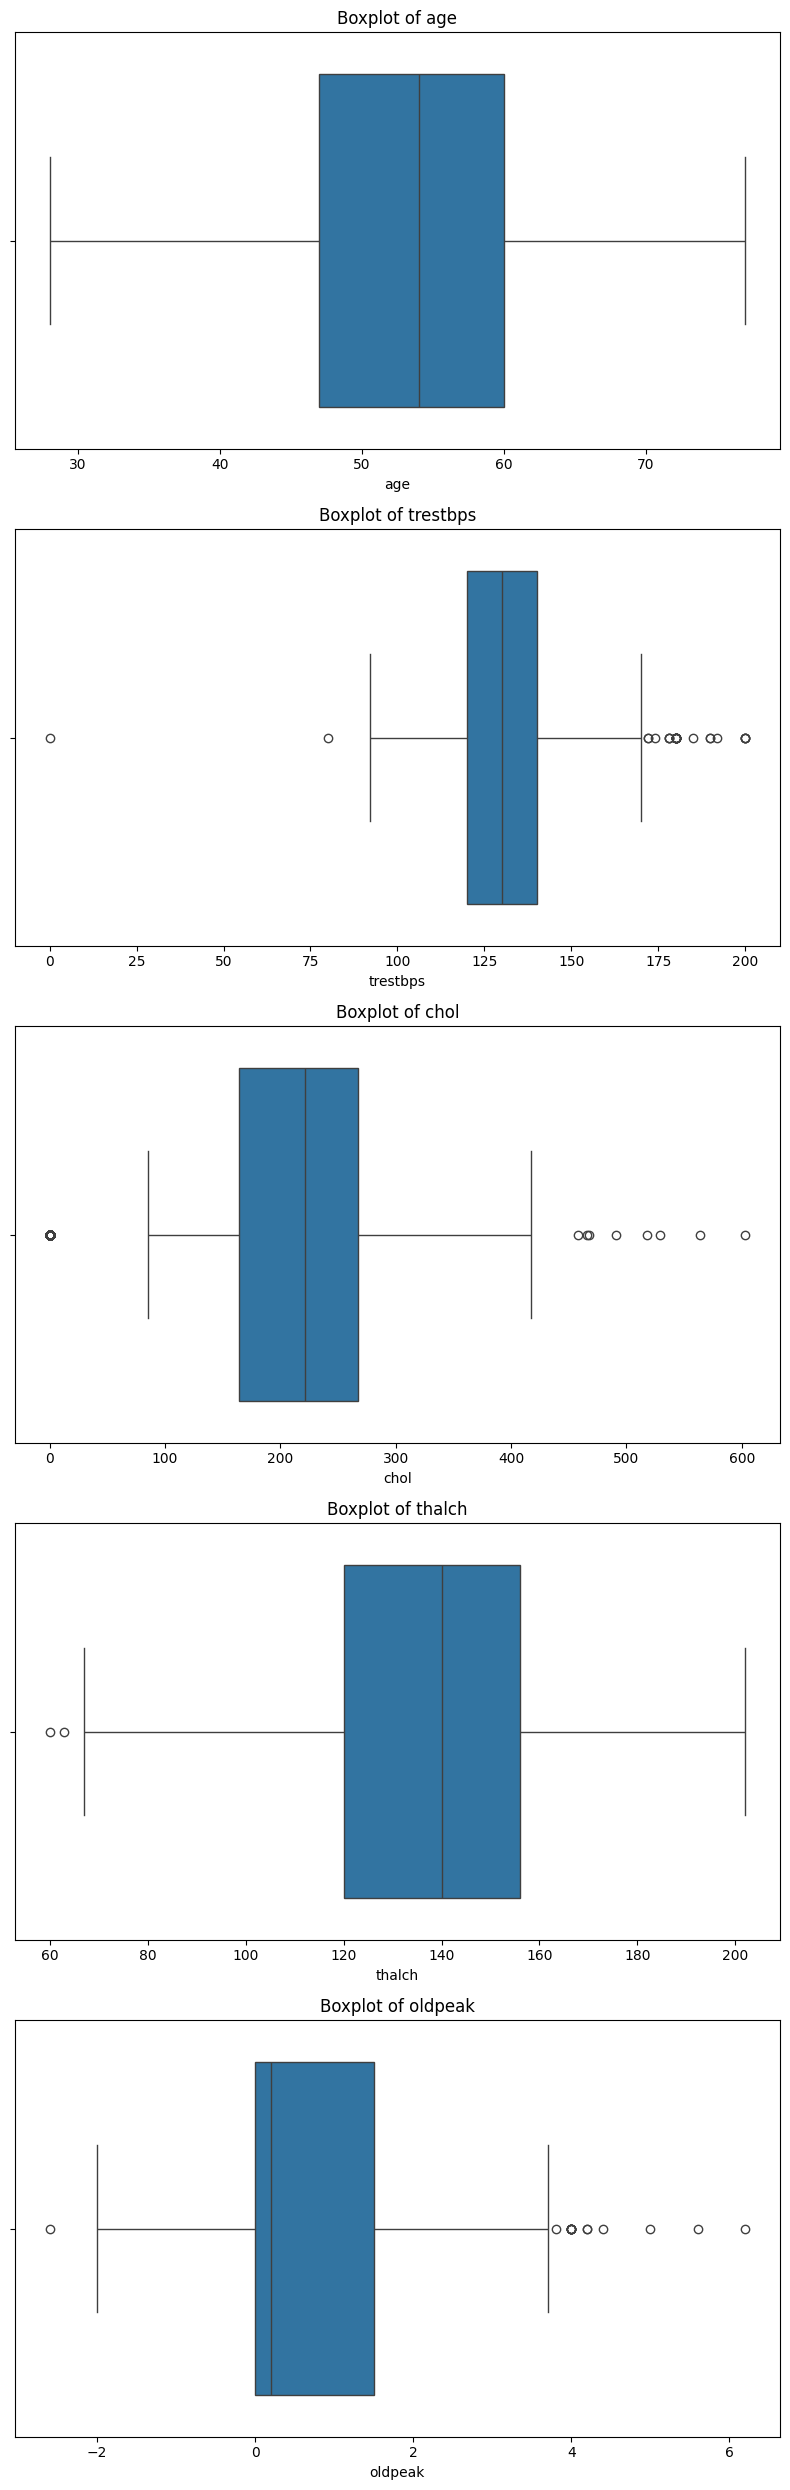

In [12]:
cols = df_processed.drop(['num','sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal','ca'], axis=1).columns
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 5*len(cols)))
for i, col in enumerate(cols):
    sns.boxplot(x=df_processed[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [27]:
cols = df_processed.drop(['num','sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal','ca'], axis=1).columns
for col in cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    valid_data = df_processed[(df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)]
    mean_value = valid_data[col].mean()
    df_processed[col] = df_processed[col].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

### **Visualizing data**

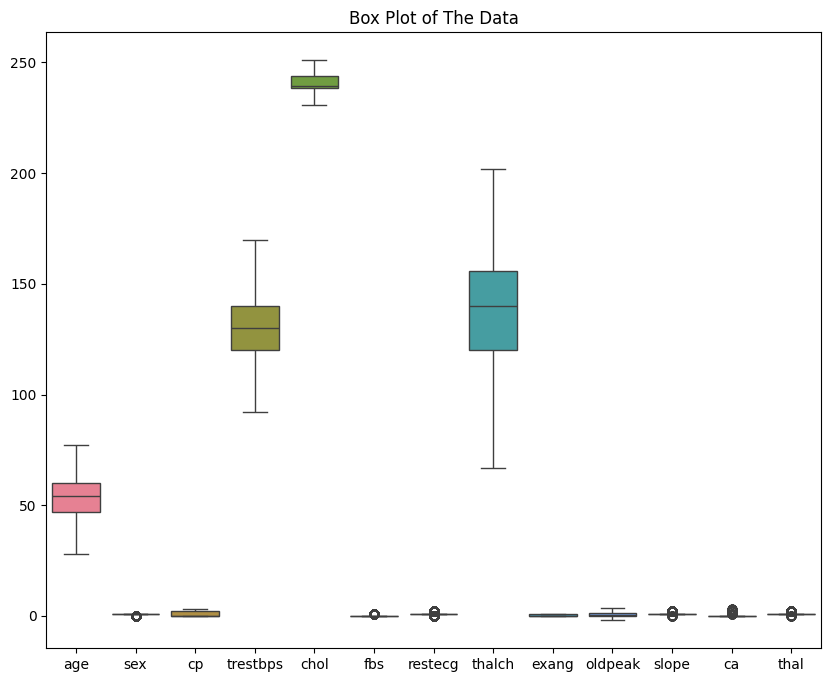

In [28]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_processed.drop(['num'],axis=1))
plt.title('Box Plot of The Data')
plt.show()

In [29]:
X = df_processed.drop('num', axis=1)  
y = (df_processed['num'] > 0).astype(int)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Single Decision Tree model**

In [30]:
base_model = DecisionTreeClassifier(random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

### **Bagging model using Decision Tree**

In [31]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  
    n_estimators=200,  
    max_samples=0.8,  
    bootstrap=True,  
    random_state=42
)
bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)

### **XGBoost classifier**

In [32]:
xgb_model = XGBClassifier(
    n_estimators=1000,   
    learning_rate=0.1,  
    max_depth=3,        
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"  
)


xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)

### **Stacking Model**

In [33]:
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),  
    ('knn', KNeighborsClassifier(n_neighbors=5)),                 
    ('svm', SVC(probability=True, kernel='linear', random_state=42))  
]

meta_learner = LogisticRegression()

#Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,  
    final_estimator=meta_learner,  
    passthrough=False,  
    cv=5  
)


stacking_model.fit(X_train, y_train)

y_pred_stacking = stacking_model.predict(X_test)

### **Evaluation Metrics(Accuracy & AUC-ROC)**

In [34]:
base_accuracy= accuracy_score(y_test, y_pred_base)
base_auc_roc = roc_auc_score(y_test, y_pred_base)

bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
bagging_auc_roc = roc_auc_score(y_test, y_pred_bagging)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc_roc = roc_auc_score(y_test, y_pred_xgb)

stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_auc_roc = roc_auc_score(y_test, y_pred_stacking)


print(f"Accuracy using Single Decision Tree: {base_accuracy:.4f}")
print(f"AUC-ROC using Single Decision Tree: {base_auc_roc:.4f}\n")

print(f"Accuracy using Bagging: {bagging_accuracy:.4f}")
print(f"AUC-ROC using Bagging: {bagging_auc_roc:.4f}\n")

print(f"Accuracy using XGBoost: {xgb_accuracy:.4f}")
print(f"AUC-ROC using XGBoost: {xgb_auc_roc:.4f}\n")

print(f"Accuracy using Stacking: {stacking_accuracy:.4f}")
print(f"AUC-ROC using Stacking: {stacking_auc_roc:.4f}")

Accuracy using Single Decision Tree: 0.7609
AUC-ROC using Single Decision Tree: 0.7670

Accuracy using Bagging: 0.8152
AUC-ROC using Bagging: 0.8128

Accuracy using XGBoost: 0.8370
AUC-ROC using XGBoost: 0.8374

Accuracy using Stacking: 0.8098
AUC-ROC using Stacking: 0.8103


### **ROC curve**

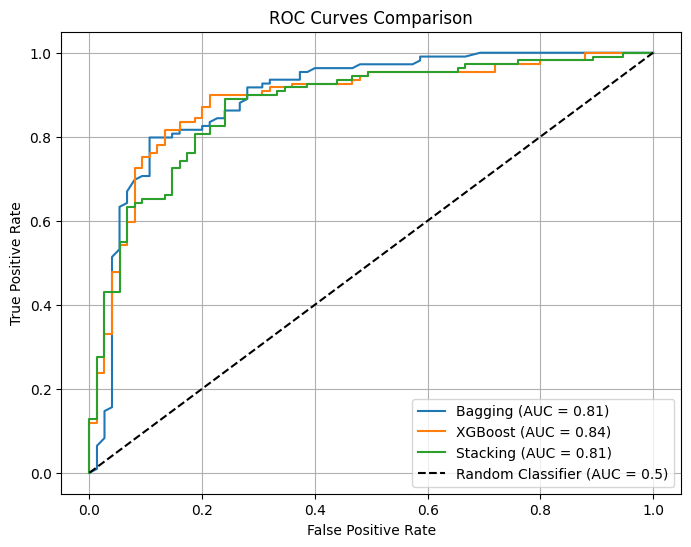

In [35]:
y_proba_bagging = bagging_model.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]


fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_proba_bagging)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_proba_stacking)


plt.figure(figsize=(8, 6))
plt.plot(fpr_bagging, tpr_bagging, label=f'Bagging (AUC = {bagging_auc_roc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc_roc:.2f})')
plt.plot(fpr_stacking, tpr_stacking, label=f'Stacking (AUC = {stacking_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### **Performance comparison**

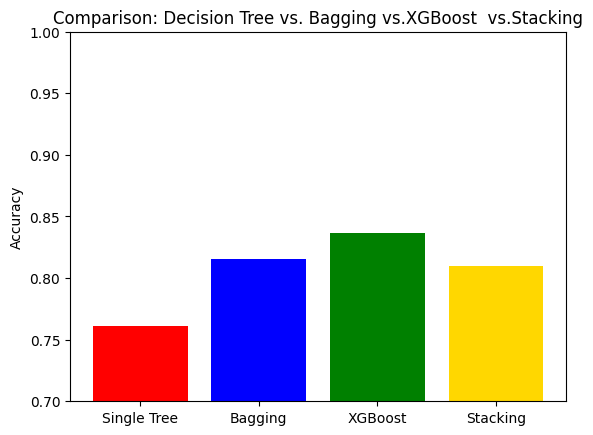

In [36]:
labels = ['Single Tree', 'Bagging','XGBoost','Stacking']
accuracies = [base_accuracy, bagging_accuracy,xgb_accuracy,stacking_accuracy]

plt.bar(labels, accuracies, color=['red', 'blue','green','gold'])
plt.ylabel('Accuracy')
plt.title('Comparison: Decision Tree vs. Bagging vs.XGBoost  vs.Stacking')
plt.ylim(0.7, 1)  
plt.show()

### **Confusion matrices for all models**

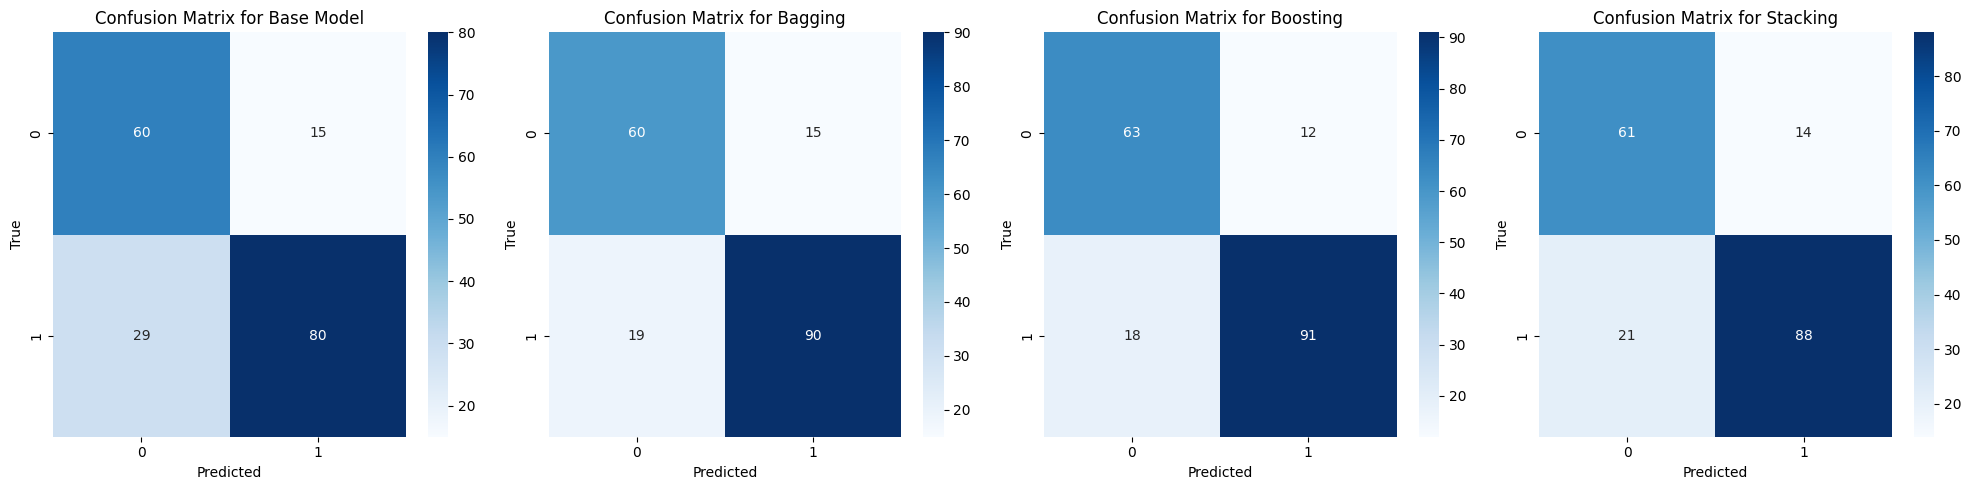

In [37]:
base_cm = confusion_matrix(y_test, y_pred_base) 
bagging_cm = confusion_matrix(y_test, y_pred_bagging)
boosting_cm = confusion_matrix(y_test, y_pred_xgb)
stacking_cm = confusion_matrix(y_test, y_pred_stacking)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))


sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2), ax=axes[0])
axes[0].set_title('Confusion Matrix for Base Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')


sns.heatmap(bagging_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2), ax=axes[1])
axes[1].set_title('Confusion Matrix for Bagging')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')


sns.heatmap(boosting_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2), ax=axes[2])
axes[2].set_title('Confusion Matrix for Boosting')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')


sns.heatmap(stacking_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2), ax=axes[3])
axes[3].set_title('Confusion Matrix for Stacking')
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('True')


plt.tight_layout()
plt.show()